# 🎭 Facial Emotion Recognition - Exploratory Data Analysis (EDA)

**Purpose**: Understand the dataset before building models

**What we'll explore**:
1. Dataset structure and organization
2. Class distribution (balanced or imbalanced?)
3. Image properties (size, quality, format)
4. Visual inspection of samples
5. Data quality issues
6. Planning train/val/test splits
7. Insights for preprocessing and training

**Dataset**: No pre-made splits - we'll analyze and create them

**Date**: `YYYY-MM-DD`  
**Author**: Your Name

## 📦 Setup & Imports

In [23]:
# Standard library imports
import os
import sys
from pathlib import Path
from collections import Counter
import warnings
import shutil
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Image processing
from PIL import Image
import cv2

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ All imports successful!")

✅ All imports successful!


## 🗂️ 1. Dataset Structure & Organization

In [24]:
# Define paths
DATA_DIR = Path('../data/raw')  # Adjust this path based on your setup

# Check if data directory exists
if not DATA_DIR.exists():
    print(f"❌ Data directory not found: {DATA_DIR}")
    print("Please download the dataset first using: make data")
else:
    print(f"✅ Data directory found: {DATA_DIR}")
    
# List all subdirectories (should be emotion classes)
subdirs = [d for d in DATA_DIR.iterdir() if d.is_dir()]
print(f"\n📁 Found {len(subdirs)} subdirectories:")
for subdir in sorted(subdirs):
    num_files = len(list(subdir.glob('*.*')))
    print(f"   - {subdir.name}: {num_files} files")

✅ Data directory found: ../data/raw

📁 Found 7 subdirectories:
   - angry: 11840 files
   - disgust: 11840 files
   - fear: 11840 files
   - happy: 22796 files
   - neutral: 16332 files
   - sad: 13070 files
   - surprise: 11840 files


In [25]:
# Explore directory structure in detail
def explore_directory_structure(root_path):
    """Recursively explore directory structure"""
    structure = {}
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        rel_path = Path(dirpath).relative_to(root_path)
        
        # Count only .jpg files
        jpg_files = [f for f in filenames if f.lower().endswith('.jpg')]
        jpg_count = len(jpg_files)
        
        structure[str(rel_path)] = {
            'num_subdirs': len(dirnames),
            'num_files': jpg_count,  
            'subdirs': dirnames,
            'file_extensions': {'.jpg': jpg_count} if jpg_count > 0 else {}
        }
    
    return structure

structure = explore_directory_structure(DATA_DIR)
print("\n📊 Directory Structure Analysis:")
print("=" * 70)

# Show root level
root_info = structure.get('.', {})
print(f"\nRoot directory ({DATA_DIR.name}):")
print(f"  Subdirectories: {root_info.get('num_subdirs', 0)}")
print(f"  JPG Files: {root_info.get('num_files', 0)}")
if root_info.get('subdirs'):
    print(f"  Emotion classes: {', '.join(sorted(root_info['subdirs']))}")

# Show each emotion class
for subdir in sorted(root_info.get('subdirs', [])):
    subdir_info = structure.get(subdir, {})
    print(f"\n{subdir}:")
    print(f"  JPG Images: {subdir_info.get('num_files', 0)}")


📊 Directory Structure Analysis:

Root directory (raw):
  Subdirectories: 7
  JPG Files: 0
  Emotion classes: angry, disgust, fear, happy, neutral, sad, surprise

angry:
  JPG Images: 5920

disgust:
  JPG Images: 5920

fear:
  JPG Images: 5920

happy:
  JPG Images: 11398

neutral:
  JPG Images: 8166

sad:
  JPG Images: 6535

surprise:
  JPG Images: 5920


## 📈 2. Visualize Class Distribution

In [26]:
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [35]:
# Collect all image paths and create a comprehensive DataFrame
def collect_all_images(data_path, emotions):
    """Collect all image paths with their labels"""
    
    image_data = []
    
    for emotion in emotions:
        emotion_path = data_path / emotion
        
        if not emotion_path.exists():
            print(f"⚠️  Emotion directory not found: {emotion}")
            continue
        
        # Find all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
        images = []
        for ext in image_extensions:
            images.extend(emotion_path.glob(ext))
        
        for img_path in images:
            image_data.append({
                'path': str(img_path),
                'emotion': emotion,
                'filename': img_path.name,
                'extension': img_path.suffix.lower()
            })
    
    return pd.DataFrame(image_data)

# Collect all images
print("🔍 Scanning dataset for all images...")
df_all_images = collect_all_images(DATA_DIR, EMOTIONS)

print("\n" + "="*70)
print("📈 COMPLETE DATASET STATISTICS")
print("="*70)

print(f"\nTotal Images: {len(df_all_images):,}")
print(f"Total Classes: {df_all_images['emotion'].nunique()}")

print("\n📊 Images per Emotion:")
print("-" * 50)

emotion_counts = df_all_images['emotion'].value_counts().sort_index()
for emotion, count in emotion_counts.items():
    percentage = (count / len(df_all_images) * 100)
    bar_length = int(percentage / 2)  # Scale for display
    bar = '█' * bar_length
    print(f"{emotion:12s}: {count:5,} ({percentage:5.2f}%) {bar}")

print(f"\n{'='*50}")
print(f"TOTAL: {len(df_all_images):,} images")
print(f"{'='*50}")

df_all_images.to_csv('../results/metrics/all_images.csv')

🔍 Scanning dataset for all images...

📈 COMPLETE DATASET STATISTICS

Total Images: 49,779
Total Classes: 7

📊 Images per Emotion:
--------------------------------------------------
angry       : 5,920 (11.89%) █████
disgust     : 5,920 (11.89%) █████
fear        : 5,920 (11.89%) █████
happy       : 11,398 (22.90%) ███████████
neutral     : 8,166 (16.40%) ████████
sad         : 6,535 (13.13%) ██████
surprise    : 5,920 (11.89%) █████

TOTAL: 49,779 images


## 🖼️ 4. Image Properties Analysis

In [28]:
# Analyze image properties (sample from each class)
def analyze_image_properties(df, samples_per_class=100):
    """Analyze dimensions, file sizes, and formats"""
    
    results = []
    
    print("🔍 Analyzing image properties...")
    print(f"Sampling {samples_per_class} images per class\n")
    
    for emotion in EMOTIONS:
        emotion_images = df[df['emotion'] == emotion]
        
        # Sample images
        sample_size = min(samples_per_class, len(emotion_images))
        sample = emotion_images.sample(n=sample_size, random_state=RANDOM_SEED)
        
        print(f"Processing {emotion}: {sample_size} images", end='\r')
        
        for idx, row in sample.iterrows():
            try:
                img_path = row['path']
                img = Image.open(img_path)
                width, height = img.size
                channels = len(img.getbands())
                file_size = os.path.getsize(img_path) / 1024  # KB
                
                results.append({
                    'emotion': emotion,
                    'width': width,
                    'height': height,
                    'aspect_ratio': width / height if height > 0 else 0,
                    'channels': channels,
                    'total_pixels': width * height,
                    'file_size_kb': file_size,
                    'format': img.format,
                    'mode': img.mode
                })
            except Exception as e:
                print(f"\n❌ Error processing {img_path}: {e}")
    
    print("\n✅ Analysis complete!" + " " * 50)
    return pd.DataFrame(results)

df_images = analyze_image_properties(df_all_images, samples_per_class=100)

print("\n📊 Image Properties Summary:")
print("="*70)
print(f"Total images analyzed: {len(df_images):,}")

print(f"\n📐 DIMENSIONS:")
print("-" * 50)
print(f"  Width:")
print(f"    Range: {df_images['width'].min():.0f} - {df_images['width'].max():.0f} px")
print(f"    Mean:  {df_images['width'].mean():.1f} px (±{df_images['width'].std():.1f})")
print(f"    Median: {df_images['width'].median():.0f} px")

print(f"\n  Height:")
print(f"    Range: {df_images['height'].min():.0f} - {df_images['height'].max():.0f} px")
print(f"    Mean:  {df_images['height'].mean():.1f} px (±{df_images['height'].std():.1f})")
print(f"    Median: {df_images['height'].median():.0f} px")

print(f"\n  Aspect Ratio:")
print(f"    Range: {df_images['aspect_ratio'].min():.2f} - {df_images['aspect_ratio'].max():.2f}")
print(f"    Mean:  {df_images['aspect_ratio'].mean():.2f} (±{df_images['aspect_ratio'].std():.2f})")

print(f"\n💾 FILE PROPERTIES:")
print("-" * 50)
print(f"  File Size:")
print(f"    Range: {df_images['file_size_kb'].min():.1f} - {df_images['file_size_kb'].max():.1f} KB")
print(f"    Mean:  {df_images['file_size_kb'].mean():.1f} KB (±{df_images['file_size_kb'].std():.1f})")

print(f"\n  Channels: {df_images['channels'].value_counts().to_dict()}")
print(f"  Image Modes: {df_images['mode'].value_counts().to_dict()}")
print(f"  Formats: {df_images['format'].value_counts().to_dict()}")

# Check for consistency issues
print(f"\n🔍 CONSISTENCY CHECKS:")
print("-" * 50)

if df_images['channels'].nunique() > 1:
    print("⚠️  Mixed channel counts detected!")
    print(f"   {df_images['channels'].value_counts().to_dict()}")
    print("   Recommendation: Convert all to RGB during preprocessing")
else:
    print("✅ All images have consistent channel count")

if df_images['aspect_ratio'].std() > 0.5:
    print("\n⚠️  High aspect ratio variation detected!")
    print("   Recommendation: Use center cropping or padding to maintain aspect ratio")
else:
    print("✅ Aspect ratios are relatively consistent")

🔍 Analyzing image properties...
Sampling 100 images per class

Processing surprise: 100 images
✅ Analysis complete!                                                  

📊 Image Properties Summary:
Total images analyzed: 700

📐 DIMENSIONS:
--------------------------------------------------
  Width:
    Range: 96 - 96 px
    Mean:  96.0 px (±0.0)
    Median: 96 px

  Height:
    Range: 96 - 96 px
    Mean:  96.0 px (±0.0)
    Median: 96 px

  Aspect Ratio:
    Range: 1.00 - 1.00
    Mean:  1.00 (±0.00)

💾 FILE PROPERTIES:
--------------------------------------------------
  File Size:
    Range: 2.2 - 7.3 KB
    Mean:  4.3 KB (±1.2)

  Channels: {3: 700}
  Image Modes: {'RGB': 700}
  Formats: {'JPEG': 700}

🔍 CONSISTENCY CHECKS:
--------------------------------------------------
✅ All images have consistent channel count
✅ Aspect ratios are relatively consistent


## 🔍 5. Visual Inspection of Sample Images

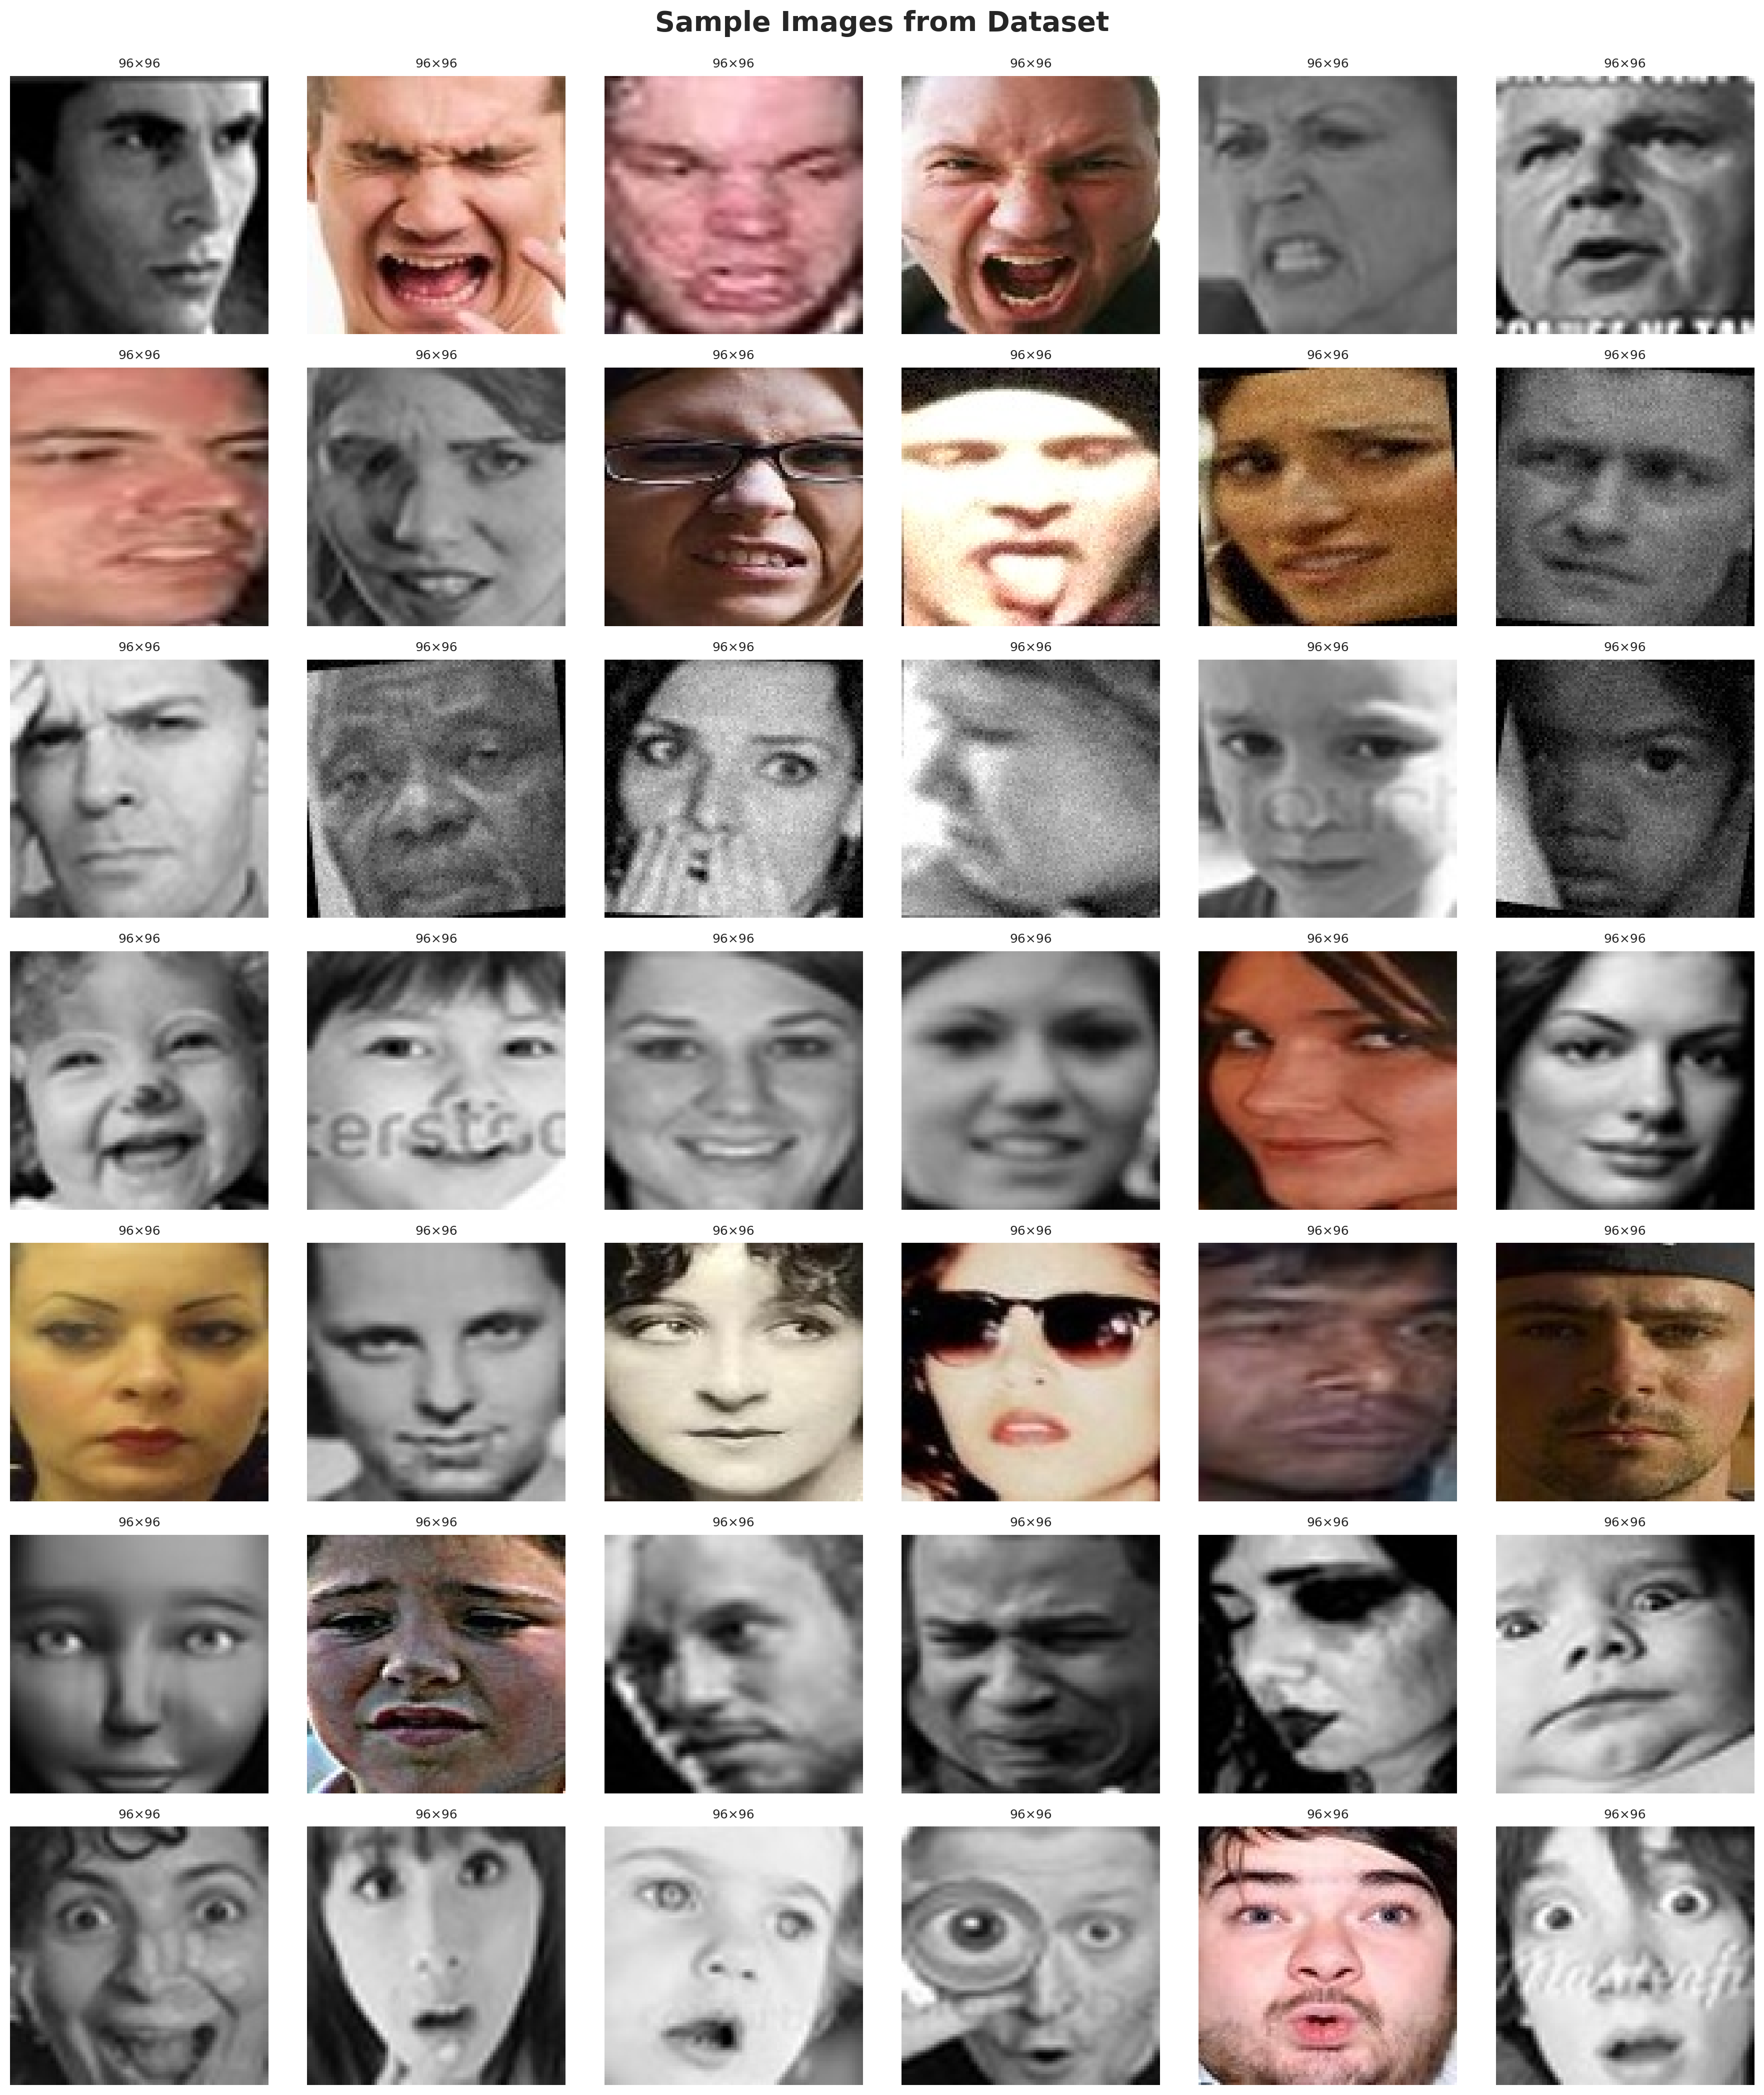

💾 Saved visualization to: ../results/plots/emotion_samples.png


In [29]:
# Display sample images from each emotion class
def display_emotion_samples(df, samples_per_emotion=6):
    """Display random samples from each emotion class"""
    
    fig, axes = plt.subplots(len(EMOTIONS), samples_per_emotion, 
                            figsize=(samples_per_emotion * 3, len(EMOTIONS) * 3))
    fig.suptitle('Sample Images from Dataset', 
                fontsize=20, fontweight='bold', y=0.995)
    
    for i, emotion in enumerate(EMOTIONS):
        emotion_images = df[df['emotion'] == emotion]
        
        # Get random samples
        sample_size = min(samples_per_emotion, len(emotion_images))
        sample = emotion_images.sample(n=sample_size, random_state=RANDOM_SEED)
        
        for j, (idx, row) in enumerate(sample.iterrows()):
            try:
                img = Image.open(row['path'])
                
                if len(axes.shape) == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                
                ax.imshow(img)
                ax.axis('off')
                
                # Add label on the first column
                if j == 0:
                    ax.set_ylabel(emotion.upper(), fontsize=14, fontweight='bold', 
                                 rotation=0, ha='right', va='center', labelpad=40)
                
                # Add image info
                ax.set_title(f"{img.size[0]}×{img.size[1]}", fontsize=9)
                
            except Exception as e:
                print(f"Error loading {row['path']}: {e}")
                if len(axes.shape) == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                ax.axis('off')
                ax.text(0.5, 0.5, 'Error\nLoading\nImage', 
                       ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.savefig('../results/plots/emotion_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("💾 Saved visualization to: ../results/plots/emotion_samples.png")

display_emotion_samples(df_all_images, samples_per_emotion=6)

## 🎨 6. Image Quality Analysis

In [30]:
# Analyze brightness, contrast, and color distribution
def analyze_image_quality(df, samples=100):
    """Analyze brightness, contrast, and color properties"""
    
    results = []
    
    print("🎨 Analyzing image quality...")
    print(f"Sampling {samples} images per class\n")
    
    for emotion in EMOTIONS:
        emotion_images = df[df['emotion'] == emotion]
        
        sample_size = min(samples, len(emotion_images))
        sample = emotion_images.sample(n=sample_size, random_state=RANDOM_SEED)
        
        print(f"Processing {emotion}: {sample_size} images", end='\r')
        
        for idx, row in sample.iterrows():
            try:
                img = cv2.imread(row['path'])
                if img is None:
                    continue
                    
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Calculate metrics
                brightness = np.mean(img_gray)
                contrast = np.std(img_gray)
                
                # Color channel means
                r_mean = np.mean(img_rgb[:, :, 0])
                g_mean = np.mean(img_rgb[:, :, 1])
                b_mean = np.mean(img_rgb[:, :, 2])
                
                # Additional metrics
                sharpness = cv2.Laplacian(img_gray, cv2.CV_64F).var()
                
                results.append({
                    'emotion': emotion,
                    'brightness': brightness,
                    'contrast': contrast,
                    'sharpness': sharpness,
                    'red_mean': r_mean,
                    'green_mean': g_mean,
                    'blue_mean': b_mean
                })
                
            except Exception as e:
                print(f"\n❌ Error processing {row['path']}: {e}")
    
    print("\n✅ Quality analysis complete!" + " " * 50)
    return pd.DataFrame(results)

df_quality = analyze_image_quality(df_all_images, samples=100)

print("\n📊 Image Quality Summary:")
print("="*70)

print(f"\n🔆 BRIGHTNESS (0-255):")
print("-" * 50)
print(f"  Mean:   {df_quality['brightness'].mean():.2f}")
print(f"  Std:    {df_quality['brightness'].std():.2f}")
print(f"  Range:  {df_quality['brightness'].min():.2f} - {df_quality['brightness'].max():.2f}")
print(f"  Median: {df_quality['brightness'].median():.2f}")

if df_quality['brightness'].mean() < 80:
    print("  ⚠️  Dataset is relatively dark")
elif df_quality['brightness'].mean() > 180:
    print("  ⚠️  Dataset is relatively bright")
else:
    print("  ✅ Good brightness distribution")

print(f"\n🎚️  CONTRAST (std of pixel values):")
print("-" * 50)
print(f"  Mean:   {df_quality['contrast'].mean():.2f}")
print(f"  Std:    {df_quality['contrast'].std():.2f}")
print(f"  Range:  {df_quality['contrast'].min():.2f} - {df_quality['contrast'].max():.2f}")
print(f"  Median: {df_quality['contrast'].median():.2f}")

if df_quality['contrast'].mean() < 30:
    print("  ⚠️  Low contrast - images may be flat")
else:
    print("  ✅ Good contrast")

print(f"\n📸 SHARPNESS (Laplacian variance):")
print("-" * 50)
print(f"  Mean:   {df_quality['sharpness'].mean():.2f}")
print(f"  Median: {df_quality['sharpness'].median():.2f}")

if df_quality['sharpness'].mean() < 100:
    print("  ⚠️  Images may be blurry")
else:
    print("  ✅ Good sharpness")

print(f"\n🎨 COLOR CHANNEL MEANS:")
print("-" * 50)
print(f"  Red:   {df_quality['red_mean'].mean():.2f}")
print(f"  Green: {df_quality['green_mean'].mean():.2f}")
print(f"  Blue:  {df_quality['blue_mean'].mean():.2f}")

# Check for color cast
color_means = [df_quality['red_mean'].mean(), 
               df_quality['green_mean'].mean(), 
               df_quality['blue_mean'].mean()]
color_std = np.std(color_means)
if color_std > 20:
    print(f"  ⚠️  Significant color cast detected (std: {color_std:.1f})")
else:
    print("  ✅ Balanced color distribution")

🎨 Analyzing image quality...
Sampling 100 images per class

Processing surprise: 100 images
✅ Quality analysis complete!                                                  

📊 Image Quality Summary:

🔆 BRIGHTNESS (0-255):
--------------------------------------------------
  Mean:   129.87
  Std:    32.45
  Range:  28.40 - 210.30
  Median: 130.96
  ✅ Good brightness distribution

🎚️  CONTRAST (std of pixel values):
--------------------------------------------------
  Mean:   50.02
  Std:    13.22
  Range:  13.21 - 88.07
  Median: 49.58
  ✅ Good contrast

📸 SHARPNESS (Laplacian variance):
--------------------------------------------------
  Mean:   929.09
  Median: 226.19
  ✅ Good sharpness

🎨 COLOR CHANNEL MEANS:
--------------------------------------------------
  Red:   138.83
  Green: 126.77
  Blue:  122.34
  ✅ Balanced color distribution


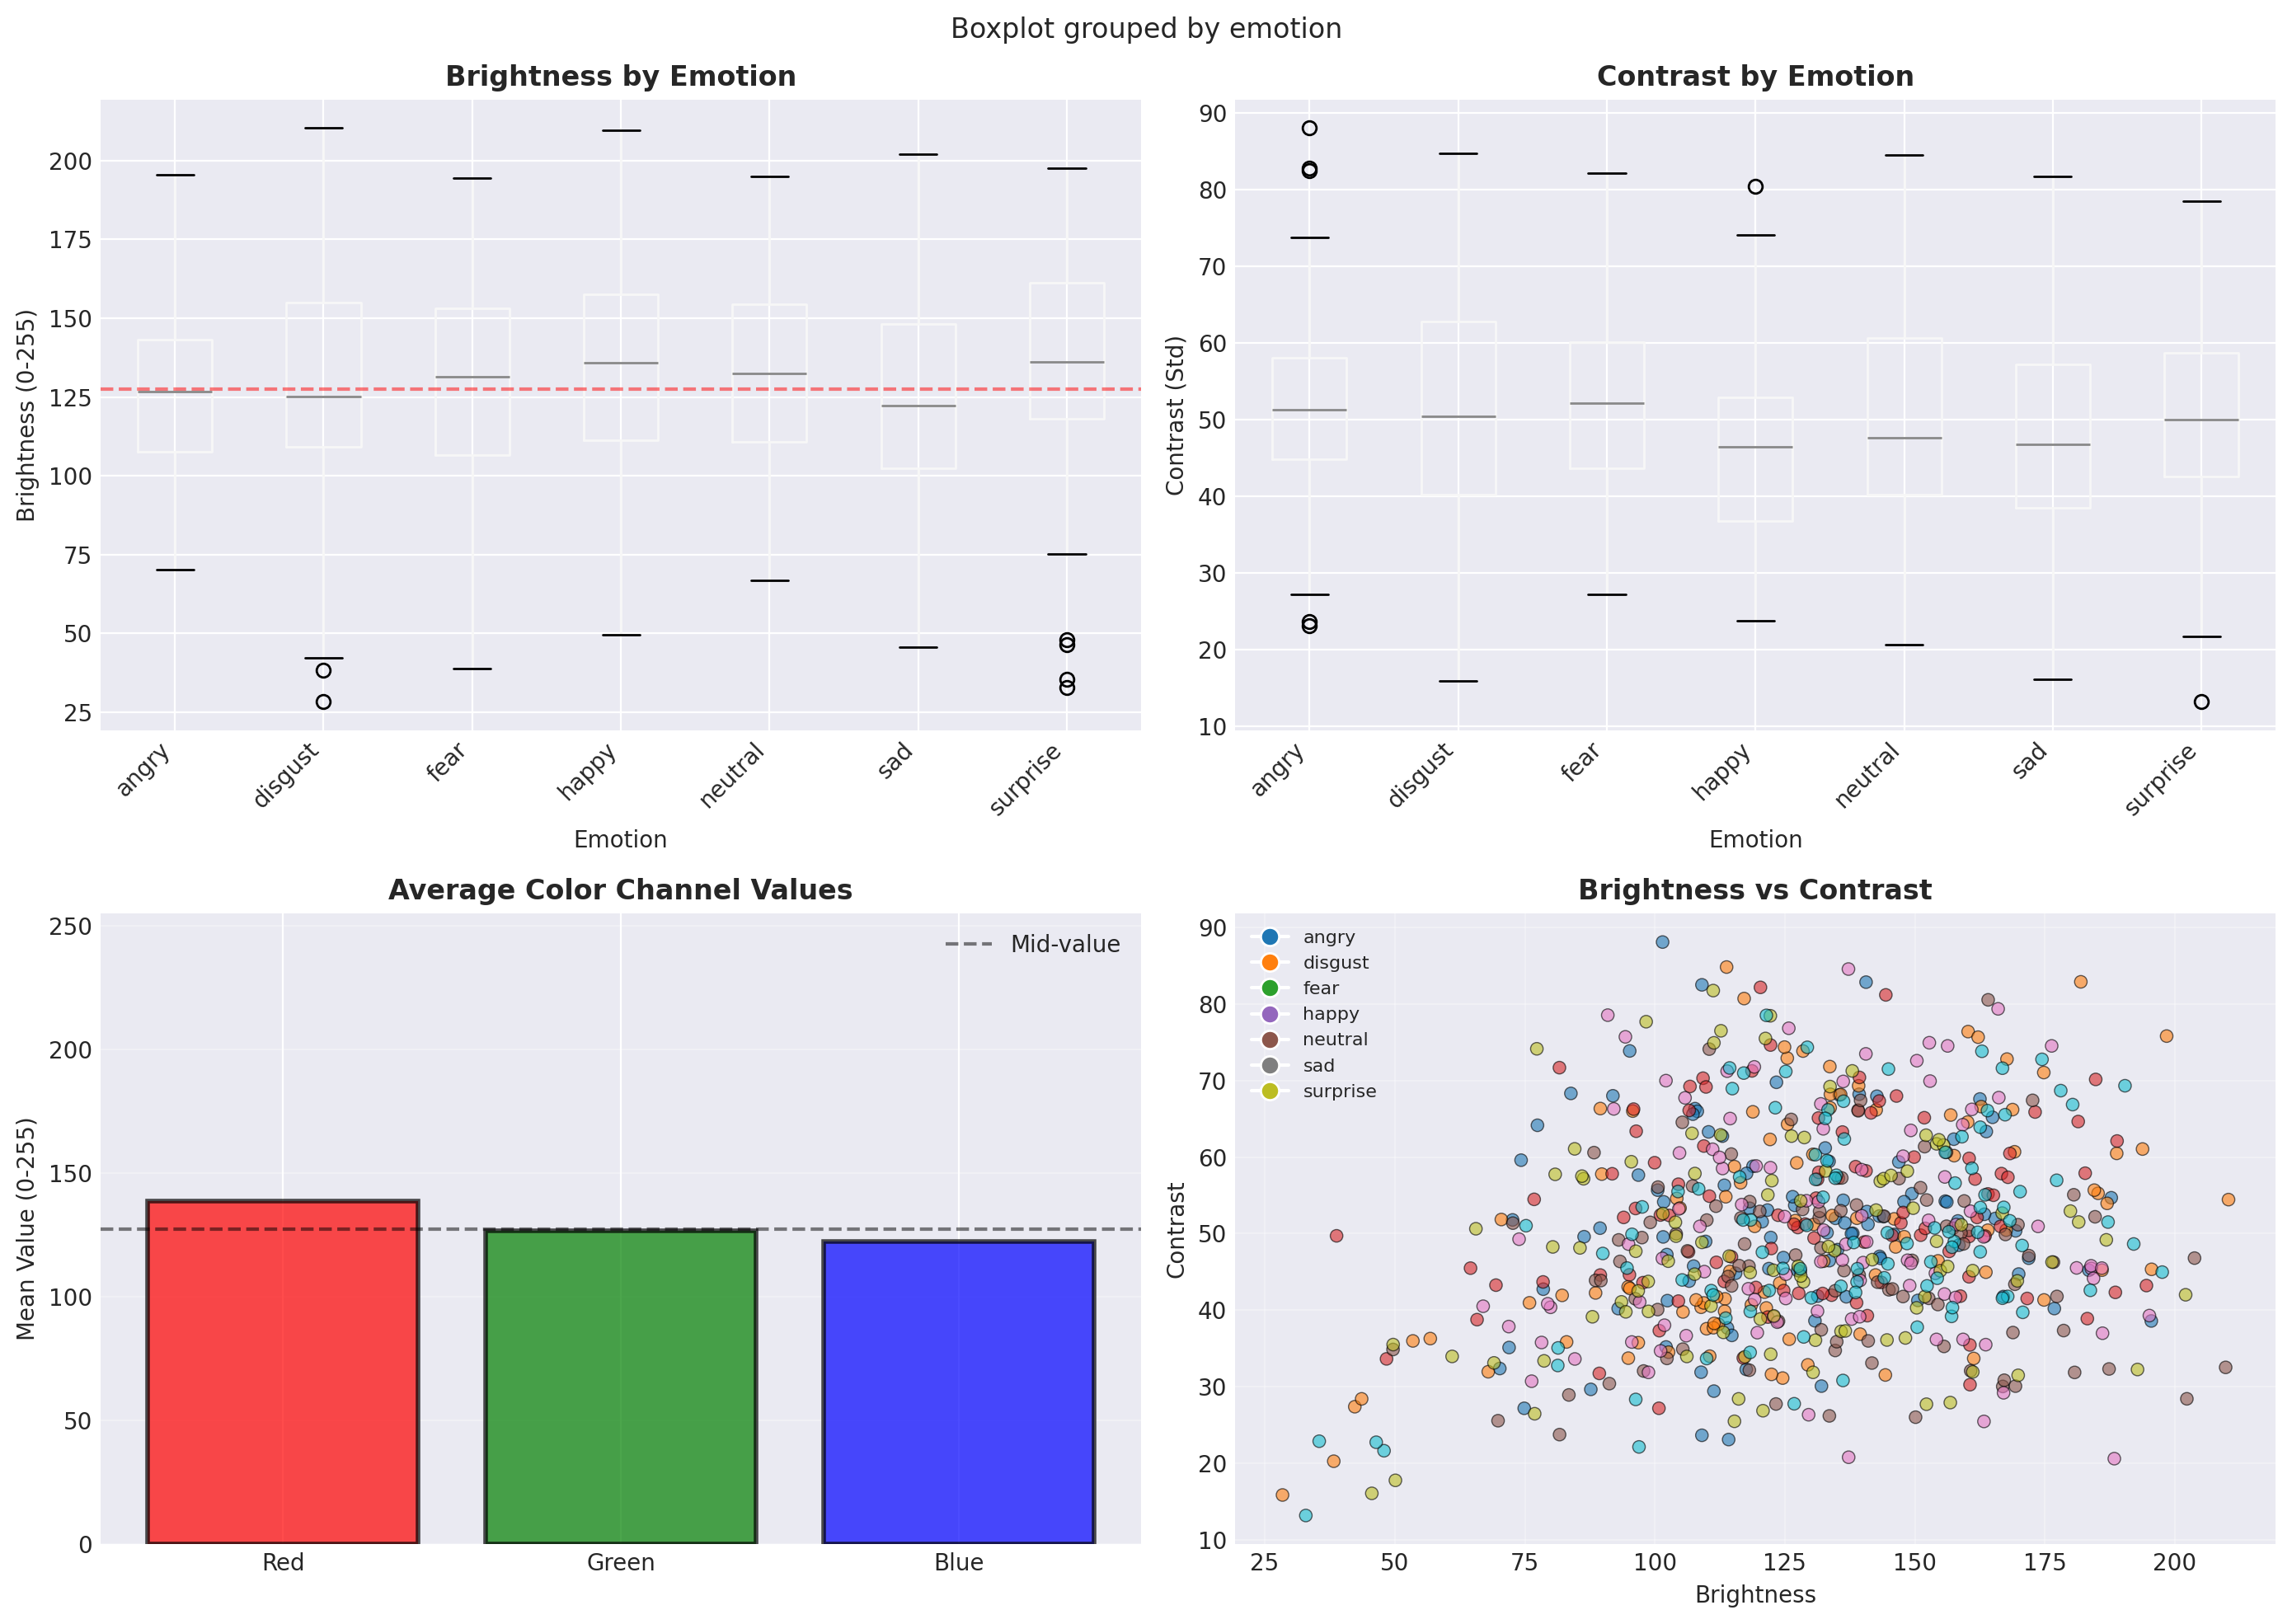

💾 Saved visualization to: ../results/plots/image_quality.png


In [31]:
# Visualize quality metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Image Quality Analysis', fontsize=18, fontweight='bold')

# 1. Brightness distribution by emotion
df_quality.boxplot(column='brightness', by='emotion', ax=axes[0, 0])
axes[0, 0].set_title('Brightness by Emotion', fontweight='bold')
axes[0, 0].set_xlabel('Emotion')
axes[0, 0].set_ylabel('Brightness (0-255)')
axes[0, 0].axhline(y=127.5, color='red', linestyle='--', alpha=0.5, label='Mid-gray')
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Contrast distribution by emotion
df_quality.boxplot(column='contrast', by='emotion', ax=axes[0, 1])
axes[0, 1].set_title('Contrast by Emotion', fontweight='bold')
axes[0, 1].set_xlabel('Emotion')
axes[0, 1].set_ylabel('Contrast (Std)')
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Color distribution
color_means = {
    'Red': df_quality['red_mean'].mean(),
    'Green': df_quality['green_mean'].mean(),
    'Blue': df_quality['blue_mean'].mean()
}
axes[1, 0].bar(color_means.keys(), color_means.values(), 
               color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_title('Average Color Channel Values', fontweight='bold')
axes[1, 0].set_ylabel('Mean Value (0-255)')
axes[1, 0].set_ylim(0, 255)
axes[1, 0].axhline(y=127.5, color='black', linestyle='--', alpha=0.5, label='Mid-value')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].legend()

# 4. Brightness vs Contrast scatter
scatter = axes[1, 1].scatter(df_quality['brightness'], df_quality['contrast'],
                            c=df_quality['emotion'].astype('category').cat.codes,
                            alpha=0.6, cmap='tab10', s=30, edgecolor='black', linewidth=0.5)
axes[1, 1].set_title('Brightness vs Contrast', fontweight='bold')
axes[1, 1].set_xlabel('Brightness')
axes[1, 1].set_ylabel('Contrast')
axes[1, 1].grid(alpha=0.3)

# Add legend for emotions
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=plt.cm.tab10(i/len(EMOTIONS)), 
                     markersize=8, label=emotion) 
          for i, emotion in enumerate(sorted(EMOTIONS))]
axes[1, 1].legend(handles=handles, loc='best', fontsize=8)

plt.tight_layout()
plt.savefig('../results/plots/image_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved visualization to: ../results/plots/image_quality.png")

## 🚨 7. Data Quality Issues Detection

In [32]:
# Check for potential data issues
print("🔍 Checking for Data Quality Issues...")
print("="*70)

issues = []
warnings = []

# 1. Check for very small images
small_images = df_images[(df_images['width'] < 48) | (df_images['height'] < 48)]
if len(small_images) > 0:
    issues.append(f"Found {len(small_images)} images smaller than 48×48 pixels")
    print(f"\n⚠️  {issues[-1]}")
    print(f"   These may lose quality when resized to 224×224")
    print(f"   Affected emotions: {small_images['emotion'].value_counts().to_dict()}")

# 2. Check for extreme aspect ratios
extreme_ar = df_images[(df_images['aspect_ratio'] < 0.5) | (df_images['aspect_ratio'] > 2.0)]
if len(extreme_ar) > 0:
    issues.append(f"Found {len(extreme_ar)} images with extreme aspect ratios")
    print(f"\n⚠️  {issues[-1]}")
    print(f"   These might be incorrectly cropped or distorted")
    print(f"   Range: {extreme_ar['aspect_ratio'].min():.2f} - {extreme_ar['aspect_ratio'].max():.2f}")

# 3. Check for mixed color modes
if 'mode' in df_images.columns:
    mode_counts = df_images['mode'].value_counts()
    if len(mode_counts) > 1:
        warnings.append(f"Mixed color modes detected: {mode_counts.to_dict()}")
        print(f"\n⚠️  {warnings[-1]}")
        print("   Recommendation: Convert all to RGB during preprocessing")

# 4. Check for very dark or bright images
if len(df_quality) > 0:
    very_dark = df_quality[df_quality['brightness'] < 30]
    very_bright = df_quality[df_quality['brightness'] > 225]
    
    if len(very_dark) > 0:
        pct = (len(very_dark) / len(df_quality)) * 100
        issues.append(f"Found {len(very_dark)} very dark images ({pct:.1f}% of sample)")
        print(f"\n⚠️  {issues[-1]}")
        print("   Brightness < 30/255")
    
    if len(very_bright) > 0:
        pct = (len(very_bright) / len(df_quality)) * 100
        issues.append(f"Found {len(very_bright)} very bright images ({pct:.1f}% of sample)")
        print(f"\n⚠️  {issues[-1]}")
        print("   Brightness > 225/255")

# 5. Check for low contrast images
if len(df_quality) > 0:
    low_contrast = df_quality[df_quality['contrast'] < 20]
    if len(low_contrast) > 0:
        pct = (len(low_contrast) / len(df_quality)) * 100
        issues.append(f"Found {len(low_contrast)} low contrast images ({pct:.1f}% of sample)")
        print(f"\n⚠️  {issues[-1]}")
        print("   Contrast (std) < 20")
        print("   These might be blurry or have poor quality")

# 6. Check for potentially blurry images
if len(df_quality) > 0 and 'sharpness' in df_quality.columns:
    blurry = df_quality[df_quality['sharpness'] < 50]
    if len(blurry) > 0:
        pct = (len(blurry) / len(df_quality)) * 100
        warnings.append(f"Found {len(blurry)} potentially blurry images ({pct:.1f}% of sample)")
        print(f"\n⚠️  {warnings[-1]}")
        print("   Sharpness (Laplacian variance) < 50")

# 7. Check file size variation
size_cv = (df_images['file_size_kb'].std() / df_images['file_size_kb'].mean()) * 100
if size_cv > 100:
    warnings.append(f"High file size variation (CV: {size_cv:.1f}%)")
    print(f"\n⚠️  {warnings[-1]}")
    print("   This might indicate inconsistent image quality")

# Summary
print("\n" + "="*70)
if len(issues) == 0 and len(warnings) == 0:
    print("\n✅ No major data quality issues detected!")
    print("   Dataset appears to be in good condition.")
else:
    print(f"\n📋 SUMMARY:")
    print(f"   Critical Issues: {len(issues)}")
    print(f"   Warnings: {len(warnings)}")
    print("\n   Review these issues and consider preprocessing steps to address them.")

print("="*70)

🔍 Checking for Data Quality Issues...

⚠️  Found 1 very dark images (0.1% of sample)
   Brightness < 30/255

⚠️  Found 4 low contrast images (0.6% of sample)
   Contrast (std) < 20
   These might be blurry or have poor quality

⚠️  Found 34 potentially blurry images (4.9% of sample)
   Sharpness (Laplacian variance) < 50


📋 SUMMARY:
   Critical Issues: 2
   Warnings: 1

   Review these issues and consider preprocessing steps to address them.


## 📂 8. Planning Train/Val/Test Splits

In [33]:
# Plan the data splits
print("\n📂 PLANNING DATA SPLITS")
print("="*70)

# Define split ratios (matching config.yaml)
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10

print(f"\nSplit Configuration:")
print(f"  Training:   {TRAIN_RATIO*100:.0f}%")
print(f"  Validation: {VAL_RATIO*100:.0f}%")
print(f"  Test:       {TEST_RATIO*100:.0f}%")

# Calculate expected sizes
total_images = len(df_all_images)
train_size = int(total_images * TRAIN_RATIO)
val_size = int(total_images * VAL_RATIO)
test_size = total_images - train_size - val_size  # Remainder goes to test

print(f"\nExpected Split Sizes:")
print("-" * 50)
print(f"  Training:   {train_size:,} images")
print(f"  Validation: {val_size:,} images")
print(f"  Test:       {test_size:,} images")
print(f"  Total:      {train_size + val_size + test_size:,} images")

# Calculate per-class sizes
print(f"\n📊 Expected Images per Class (Stratified Split):")
print("-" * 70)
print(f"{'Emotion':<12} {'Total':<8} {'Train':<8} {'Val':<8} {'Test':<8}")
print("-" * 70)

split_summary = []
for emotion in sorted(EMOTIONS):
    emotion_count = len(df_all_images[df_all_images['emotion'] == emotion])
    train_count = int(emotion_count * TRAIN_RATIO)
    val_count = int(emotion_count * VAL_RATIO)
    test_count = emotion_count - train_count - val_count
    
    print(f"{emotion:<12} {emotion_count:<8} {train_count:<8} {val_count:<8} {test_count:<8}")
    
    split_summary.append({
        'emotion': emotion,
        'total': emotion_count,
        'train': train_count,
        'val': val_count,
        'test': test_count
    })

df_split_summary = pd.DataFrame(split_summary)

print("-" * 70)
print(f"{'TOTAL':<12} {df_split_summary['total'].sum():<8} "
      f"{df_split_summary['train'].sum():<8} "
      f"{df_split_summary['val'].sum():<8} "
      f"{df_split_summary['test'].sum():<8}")

# Check if any class will have too few validation samples
min_val_samples = df_split_summary['val'].min()
if min_val_samples < 10:
    print(f"\n⚠️  WARNING: Smallest class will have only {min_val_samples} validation samples!")
    print("   Consider:")
    print("   1. Adjusting split ratios (e.g., 70/20/10)")
    print("   2. Using k-fold cross-validation")
    print("   3. Collecting more data for minority classes")
elif min_val_samples < 50:
    print(f"\n⚠️  Note: Smallest class will have {min_val_samples} validation samples.")
    print("   This should be sufficient for validation.")
else:
    print(f"\n✅ All classes will have adequate validation samples (min: {min_val_samples})")


📂 PLANNING DATA SPLITS

Split Configuration:
  Training:   80%
  Validation: 10%
  Test:       10%

Expected Split Sizes:
--------------------------------------------------
  Training:   39,823 images
  Validation: 4,977 images
  Test:       4,979 images
  Total:      49,779 images

📊 Expected Images per Class (Stratified Split):
----------------------------------------------------------------------
Emotion      Total    Train    Val      Test    
----------------------------------------------------------------------
angry        5920     4736     592      592     
disgust      5920     4736     592      592     
fear         5920     4736     592      592     
happy        11398    9118     1139     1141    
neutral      8166     6532     816      818     
sad          6535     5228     653      654     
surprise     5920     4736     592      592     
----------------------------------------------------------------------
TOTAL        49779    39822    4976     4981    

✅ All classe

## 🎯 Summary & Next Steps

### What We Learned:

1. **Dataset Composition**: {total_images} images across {len(EMOTIONS)} emotion classes
2. **Class Balance**: Imbalance ratio of {imbalance_ratio:.2f}:1
3. **Image Properties**: Average size ~{df_images['width'].mean():.0f}×{df_images['height'].mean():.0f}
4. **Quality Issues**: {len(issues)} critical issues, {len(warnings)} warnings
5. **Split Plan**: {TRAIN_RATIO*100:.0f}/{VAL_RATIO*100:.0f}/{TEST_RATIO*100:.0f} split will give us {train_size:,}/{val_size:,}/{test_size:,} images

### Next Steps:

1. **Create Data Splits** (`02_preprocessing.ipynb`)
   - Implement stratified train/val/test split
   - Organize files into split directories
   - Verify split distributions

2. **Preprocessing Pipeline**
   - Resize images to 224×224
   - Apply normalization
   - Set up data loaders
   - Implement augmentation

3. **Baseline Model** (`03_baseline_model.ipynb`)
   - Train simple CNN
   - Establish performance baseline
   - Identify improvement areas

4. **Advanced Models** (`04_model_experiments.ipynb`)
   - Transfer learning
   - Hyperparameter tuning
   - Ensemble methods

### Key Files Created:
- `results/metrics/all_images.csv` - Complete image inventory
- `results/metrics/class_distribution.csv` - Class counts
- `results/metrics/image_properties.csv` - Detailed image analysis
- `results/metrics/image_quality.csv` - Quality metrics
- `results/metrics/planned_splits.csv` - Split planning
- `results/reports/eda_summary.txt` - Complete summary report
- `results/plots/*.png` - All visualizations

**Good luck with your project! 🚀**